As one of the main tasks we build a link prediction model to predict future links between unconnected nodes (Facebook pages). We plan to determine our unconnected node pairs and use these as negative samples during the training of the link prediction model. We use the node2vec algorithm to extract node features from the graph after dropping the links. As the last step, we validate the performance of our future linking model and split the data to train and test set in order to get the result. We use a Logistic Regression model in order to get the predictions. 


TASK

**Link prediction** - negative sampling, node2vec to extract node features 
Logistic Regression 


In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

DATA

In [2]:
# NODES???
fb_nodes = pd.read_csv('musae_facebook_target.csv')
#fb_features = pd.read_csv('musae_facebook_features.csv')

# EDGES
fb_edges = pd.read_csv('musae_facebook_edges.csv')
fb_edges.columns = ["node_1", "node_2"]

In [3]:
fb_nodes.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [4]:
fb_nodes["id"] = fb_nodes["id"].astype(str)
#fb_nodes["id"][0]

In [5]:
fb_edges.head()

,node_1,node_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [6]:
fb_edges["node_1"] = fb_edges["node_1"].astype(str)
fb_edges["node_2"] = fb_edges["node_2"].astype(str)

#fb_edges.head()

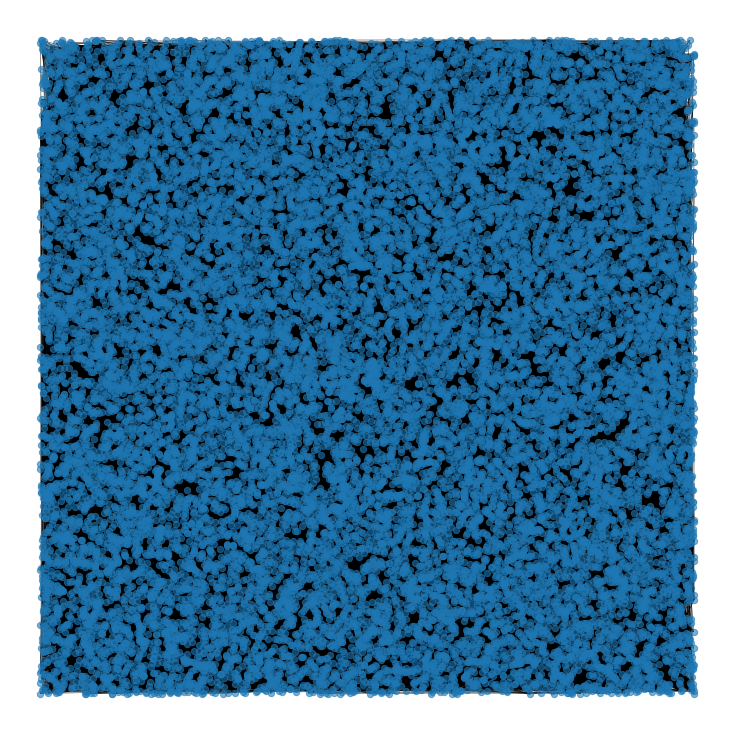

In [7]:
# Create graph
G = nx.from_pandas_edgelist(fb_edges, "node_1", "node_2", create_using=nx.Graph())

# Plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [8]:
# Combine all nodes in a list
nodes_1 = [fb_edges.node_1[i] for i in range(len(fb_edges))]
nodes_2 = [fb_edges.node_2[i] for i in range(len(fb_edges))]

node_list = list(fb_nodes["id"]) #nodes_1 + nodes_2

# Remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# Build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
# Get unconnected node-pairs
all_unconnected_pairs = []

# Traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

In [ ]:
#len(all_unconnected_pairs)

We have 3,270,620 unconnected pairs. These node pairs will act as negative samples during the training of the link prediction model. Let’s keep these pairs in a dataframe:

In [9]:
#node_1_unlinked = [all_unconnected_pairs[i]["0"] for i in range(len(all_unconnected_pairs))]
#node_2_unlinked = [all_unconnected_pairs[i]["1"] for i in range(len(all_unconnected_pairs))]

#data = pd.DataFrame({'node_1':node_1_unlinked, 
#                     'node_2':node_2_unlinked})

all_unconnected_pairs = pd.read_csv('unconnected_pairs.csv')

data = all_unconnected_pairs
data.columns = ["node_1", "node_2"]

# add target variable 'link'
data['link'] = 0

Remove Links from Connected Node Pairs – Positive Samples

As we discussed above, we will randomly drop some of the edges from the graph. However, randomly removing edges may result in cutting off loosely connected nodes and fragments of the graph. This is something that we have to take care of. We have to make sure that in the process of dropping edges, all the nodes of the graph should remain connected.

In the code block below, we will first check if dropping a node pair results in the splitting of the graph (number_connected_components > 1) or reduction in the number of nodes. If both things do not happen, then we drop that node pair and repeat the same process with the next node pair.

Eventually, we will get a list of node pairs that can be dropped from the graph and all the nodes would still remain intact:

In [ ]:
initial_node_count = len(G.nodes)

fb_edges_temp = fb_edges.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_edges.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_edges_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_edges_temp = fb_edges_temp.drop(index = i)

In [ ]:
#len(omissible_links_index)

In [10]:
omissible_links_index = pd.read_csv('omissible_links.csv')

We have over 148,533 that we can drop from the graph. These dropped edges will act as positive training examples during the link prediction model training.

Data for Model Training

Next, we will append these removable edges to the dataframe of unconnected node pairs. Since these new edges are positive samples, they will have a target value of ‘1’:

In [11]:
# Create dataframe of removable edges
fb_edges_ghost = fb_edges.loc[omissible_links_index["0"]]

# add the target variable 'link'
fb_edges_ghost['link'] = 1

data = data.append(fb_edges_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [12]:
data['link'].value_counts()

0    3270620
1     148533
Name: link, dtype: int64

It turns out that this is highly imbalanced data. The ratio of link vs no link is just close to 4.5%. In the next section, we will extract features for all these node pairs.

**Feature Extraction:** We will use the node2vec algorithm to extract node features from the graph after dropping the links. So, let’s first create a new graph after dropping the removable links:

In [13]:
# drop removable edges
#fb_edges_partial = fb_edges.drop(index=fb_edges_ghost.index.values)
# DATA FROM ANOTHER NOTEBOOK
fb_edges_partial = pd.read_csv('fb_edges_partial.csv')

# build graph
G_data = nx.from_pandas_edgelist(fb_edges_partial, "node_1", "node_2", create_using=nx.Graph())

Next, we will install the node2vec library. It is quite similar to the DeepWalk algorithm. However, it involves biased random walks. To know more about node2vec, you should definitely check out this paper node2vec: Scalable Feature Learning for Networks.

In [14]:
!pip install node2vec
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=10, min_count=1)

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=29f7f3107e23af7afa87832d5fbd265867ac67febdb80aedce8a1ac7d50f9177
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [12:54<00:00, 15.49s/it]


Next, we will apply the trained node2vec model on each and every node pair in the dataframe ‘data’. To compute the features of a pair or an edge, we will add up the features of the nodes in that pair:

In [15]:
X = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


**Building our Link Prediction Model**

To validate the performance of our model, we should split our data into two parts – one for training the model and the other to test the model’s performance:

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(np.array(X), data['link'], 
                                                test_size = 0.2, 
                                                random_state = 0)

In [35]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
predictions = lr.predict_proba(Xtest)

In [37]:
roc_auc_score(ytest, predictions[:,1])

0.7798380688708701

In [ ]:
#from sklearn.metrics import accuracy_score
#accuracy_score(ytest, predictions[:,1])

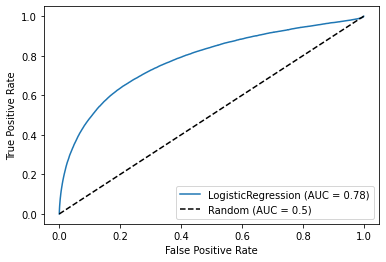

In [38]:
#import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

y_true = ytest # ground truth labels
y_probas = predictions[:,1] # predicted probabilities generated by sklearn classifier
metrics.plot_roc_curve(lr, X=Xtest, y=ytest)

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Random (AUC = 0.5)")
#plt.style.use("dark_background")
plt.legend()
plt.savefig('link_pred_plot_black.png', bbox_inches='tight')
plt.show()
#plt.style.use("dark_background")
#plt.savefig('link_pred_plot.png')